In [7]:
import numpy as np
import pandas as pd

import pandas_profiling as pp
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

TRAINPATH = '/home/izinizik/kagle_twarz/dane/training.csv'
#TESTPATH = '/home/izinizik/kagle_twarz/test.csv'

In [8]:
#use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [9]:
df_train = pd.read_csv(TRAINPATH)
#df_test = pd.read_csv(TESTPATH)

In [10]:
df_train['Image'] = df_train['Image'].apply(lambda im: np.fromstring(im, sep=' '))

In [11]:
names = ['mouth_center_top_lip_x','mouth_center_top_lip_y','Image']

In [12]:
df_train_mouth_center_top_lip = df_train[names].dropna()

In [13]:
df_train_mouth_center_top_lip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2275 entries, 0 to 2283
Data columns (total 3 columns):
mouth_center_top_lip_x    2275 non-null float64
mouth_center_top_lip_y    2275 non-null float64
Image                     2275 non-null object
dtypes: float64(2), object(1)
memory usage: 71.1+ KB


In [14]:
X = np.vstack(df_train_mouth_center_top_lip.iloc[:,2].values)/ 255. 
y = df_train_mouth_center_top_lip.iloc[:,:2].values

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [16]:
criterion = nn.MSELoss().to(device)

In [17]:
const_prediction_train = np.repeat(y_train.mean(axis=0).reshape(1,-1), y_train.shape[0], axis=0)
criterion(torch.tensor(const_prediction_train), torch.tensor(y_train)).item()

18.951412323350947

In [18]:
const_prediction_valid = np.repeat(y_train.mean(axis=0).reshape(1,-1), y_valid.shape[0], axis=0)
criterion(torch.tensor(const_prediction_valid), torch.tensor(y_valid)).item()

19.755876116847233

In [19]:
regresion_line = np.linalg.lstsq(np.column_stack([X_train, np.ones(len(X_train))]), y_train, rcond=None)[0]

In [20]:
linear_prediction_train = np.dot(X_train,regresion_line[:-1]) + regresion_line[-1:]
criterion(torch.tensor(linear_prediction_train), torch.tensor(y_train)).item()

0.20846279813084126

In [21]:
linear_prediction_valid = np.dot(X_valid,regresion_line[:-1]) + regresion_line[-1:]
criterion(torch.tensor(linear_prediction_valid), torch.tensor(y_valid)).item()

25.68948378131157

In [33]:
def plot_sample(images_array, dim=1, key=np.empty([10000,0]), key_pred=np.empty([10000,0])):
    
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    sample = np.random.choice(len(images_array), dim*dim)
    for i in range(dim*dim):
        ax = fig.add_subplot(dim, dim, i + 1, xticks=[], yticks=[])
        ax.imshow(images_array[sample[i]].reshape(96,96), cmap='gray')
        ax.scatter(key[sample[i],0::2], key[sample[i],1::2], s=20, marker='.', c='red')
        ax.scatter(key_pred[sample[i],0::2], key_pred[sample[i],1::2], s=20, marker='.', c='blue')

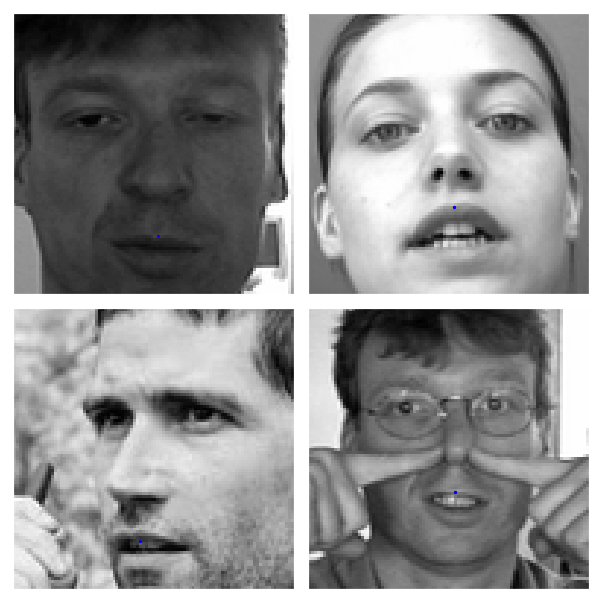

In [38]:
plot_sample(X_train, dim=2, key=y_train, key_pred=linear_prediction_train) 

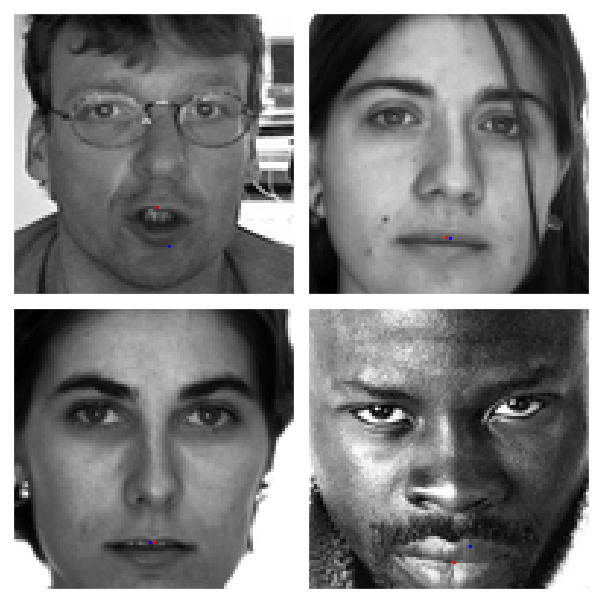

In [43]:
plot_sample(X_valid, dim=2, key=y_valid, key_pred=linear_prediction_valid) 

In [22]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.data = torch.tensor(X).type(dtype).reshape(-1,1,96,96).to(device)
        self.label = torch.tensor(y).type(dtype).to(device)
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return self.len

In [23]:
dataset_train = MyDataset(X_train, y_train)
train_loader = DataLoader(dataset=dataset_train,
                          batch_size=100,
                          shuffle=True,
                          num_workers=4)

In [24]:
dataset_valid = MyDataset(X_valid, y_valid)
valid_loader = DataLoader(dataset=dataset_valid,
                          batch_size=100,
                          shuffle=True,
                          num_workers=4)

In [25]:
class ConvNet(nn.Module):

    def __init__(self):

        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.1)
        self.drop3 = nn.Dropout(p = 0.1)
        self.drop4 = nn.Dropout(p = 0.2)
        self.drop5 = nn.Dropout(p = 0.2)
        
        self.fc1 = nn.Linear(in_features=32*3*3, out_features=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
      
    def forward(self, x):
        
        x = self.drop1(self.pool(F.relu(self.conv1(x))))
        x = self.drop2(self.pool(F.relu(self.conv2(x))))
        x = self.drop3(self.pool(F.relu(self.conv3(x))))
        x = self.drop4(self.pool(F.relu(self.conv4(x))))
        x = self.drop5(self.pool(F.relu(self.conv5(x))))
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)

        return(x)

In [26]:
def train_net(net, n_epochs=500, store_every=10, print_every=10):

    hist = {'train': [], 'valid': []}
    
    
    for epoch in range(n_epochs): 
        
        loss_sum = 0.0
        n_loss = 0
        net.train()
        
        for i, data in enumerate(train_loader, 0):
            input_train, label_train = data
            output_train = net(input_train) 
            loss = criterion(output_train, label_train)
            loss_sum += loss.item()
            n_loss += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % store_every == 0:               
            hist['train'].append(loss_sum/n_loss)
            loss_sum_valid = 0.0
            n_loss_valid = 0
            net.eval()
            for i, data in enumerate(valid_loader, 0):
                input_valid, label_valid = data
                output_valid = net(input_valid) 
                loss_valid = criterion(output_valid, label_valid)
                loss_sum_valid += loss_valid.item()
                n_loss_valid += 1
            hist['valid'].append(loss_sum_valid/n_loss_valid)


        if epoch % print_every == 0:        
            print('Epoch: {}, Loss train: {}, Loss valid: {}'.format(epoch+1, loss_sum/n_loss, loss_sum_valid/n_loss_valid))
    print('Epoch: {}, Loss train: {}, Loss valid: {}'.format(epoch+1, loss_sum/n_loss, loss_sum_valid/n_loss_valid))
    return net, hist

In [27]:
convnet = ConvNet().to(device)

In [30]:
optimizer = optim.Adam(params = convnet.parameters(), lr = 0.001)

In [44]:
Convnet_trained, hist = train_net(convnet, n_epochs=100, store_every=10, print_every=10)

Epoch: 1, Loss train: 16.131311469607883, Loss valid: 11.702073494593302
Epoch: 11, Loss train: 15.704916662640041, Loss valid: 12.776174704233805
Epoch: 21, Loss train: 17.13099431991577, Loss valid: 10.129453182220459
Epoch: 31, Loss train: 14.650491661495632, Loss valid: 10.757242202758789
Epoch: 41, Loss train: 15.379152774810791, Loss valid: 9.558642943700155
Epoch: 51, Loss train: 14.737448983722263, Loss valid: 9.654753684997559
Epoch: 61, Loss train: 14.65851714875963, Loss valid: 9.262155532836914
Epoch: 71, Loss train: 14.118383778466118, Loss valid: 10.264003356297811
Epoch: 81, Loss train: 14.596931510501438, Loss valid: 9.692754109700521
Epoch: 91, Loss train: 15.205988301171196, Loss valid: 8.993101835250854
Epoch: 100, Loss train: 13.554437557856241, Loss valid: 8.993101835250854


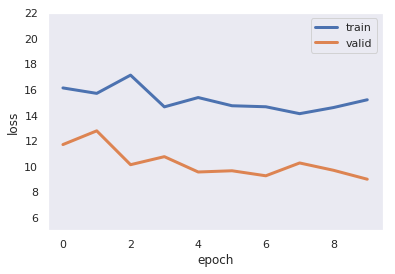

In [46]:
 def train_valid_plot(train, valid):
    plt.plot(train, linewidth=3, label="train")
    plt.plot(valid, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.ylim(5, 22) 
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
train_valid_plot(hist['train'], hist['valid'])

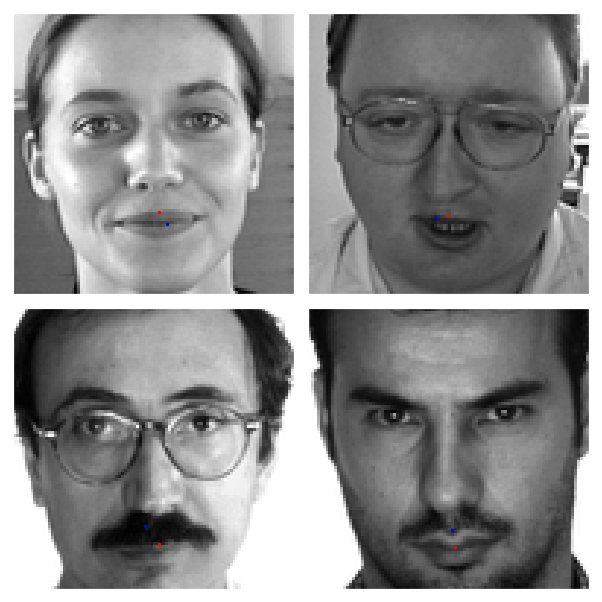

In [49]:
y_pred = Convnet_trained(torch.tensor(X_valid[:100]).float().reshape(-1,1,96,96)).detach().numpy()
plot_sample(X_valid[:100], dim=2, key=y_valid[:100], key_pred=y_pred) 

In [50]:
torch.save(Convnet_trained.state_dict(), 'wagi_mouth_center_top_lip.pt')

In [ ]:
convnet.load_state_dict(torch.load('wagi_mouth_center_top_lip.pt'))

In [52]:
y_pred.T

array([[47.30144 , 48.948723, 42.450684, 45.440212, 47.156197, 47.8614  ,
        48.960197, 46.32286 , 45.566166, 46.499416, 46.92466 , 47.29422 ,
        47.760685, 50.22611 , 46.685677, 49.380203, 51.896618, 50.316025,
        46.014824, 47.172836, 49.822334, 48.93075 , 47.69771 , 45.09677 ,
        50.428513, 49.641396, 45.10185 , 45.136547, 52.47772 , 47.137695,
        48.69534 , 47.041153, 48.26357 , 49.81796 , 48.420345, 50.73394 ,
        46.43877 , 50.97988 , 44.97419 , 45.101715, 49.82044 , 47.447548,
        52.029564, 50.45526 , 46.561295, 51.30731 , 48.21165 , 46.586082,
        51.902607, 48.53512 , 47.274807, 45.98245 , 45.492363, 43.30793 ,
        44.78244 , 46.62156 , 49.675667, 50.37081 , 45.44337 , 44.476524,
        46.05978 , 43.16504 , 45.334526, 47.2142  , 51.924843, 48.63634 ,
        53.237236, 44.794956, 50.684708, 51.694702, 46.78559 , 45.165127,
        45.78721 , 46.134544, 43.69595 , 47.201614, 45.11105 , 48.927917,
        47.27109 , 50.15921 , 47.86877